In [1]:
import os
import cv2
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta
from shapely import geometry
from tqdm import tqdm
import imageio

from scipy.special import gamma
from skimage import color

In [2]:

def reactiv(inputs, date_vector):

    N = inputs.shape[0]
    
    nx = inputs.shape[1]
    ny = inputs.shape[2]
    
    im = inputs[0,:,:]
    threshold = 5 * im.mean()
    
    m1 = im
    m2 = im**2
    Imax = im
    
    ds = float(max(date_vector) - min(date_vector))
    
    M1 = np.zeros([nx, ny])
    M2 = np.zeros([nx, ny]) 
    Kmax = np.zeros([nx, ny]) 
    Imax = np.zeros([nx, ny])
    
    k=0
    for i in range(0, N):
        im = inputs[i,:,:]
        M1 = M1 + im
        M2 = M2 + im**2
        Matrix_indicek = (date_vector[k] - min(date_vector)) / ds * np.ones([nx, ny])
        k = k + 1
        Kmax = (im > Imax) * Matrix_indicek + (im < Imax) * Kmax 
        Imax = np.maximum(Imax, im)

    M1 = M1 / N
    M2 = M2 / N
    R = np.sqrt(M2 - M1**2) / M1

    gam = R.mean()
    L = ((0.991936 + 0.067646 * gam - 0.098888 * gam**2 - 0.048320 * gam**3) / (0.001224 - 0.034323 * gam + 4.305577 * gam**2 - 1.163498 * gam**3))

    CV = np.sqrt((L * gamma(L)**2 / (gamma(L + 0.5)**2)) - 1) # theretical mean value
    num = (L * gamma(L)**4. * (4 * (L**2) * gamma(L)**2 - 4 * L * gamma(L + 1 / 2)**2 - gamma(L + 1 / 2)**2))
    den = (gamma(L + 1 / 2)**4.*(L * gamma(L)**2 - gamma(L + 1 / 2)**2))
    alpha = 1 / 4 * num / den # theretical standard deviation value

    R = (R - CV) / (alpha / np.sqrt(N)) / 10.0 + 0.25;
    R = (R > 1) * np.ones([nx, ny]) + (R < 1) * R;   # Cast Coefficient of Varation R max to 1.
    R = (R > 0) * R;

    I = (Imax / threshold) # Cast Intensity to threshold. 
    I = (I < 1) * I + (I > 1) * np.ones([nx, ny])

    hsv = np.zeros([nx, ny, 3])
    hsv[:, :, 0] = Kmax
    hsv[:, :, 1] = R 
    hsv[:, :, 2] = I 

    C = color.hsv2rgb(hsv)
    
    return C

In [3]:
# from scipy.ndimage import uniform_filter
# from scipy.ndimage import variance

# def lee_filter(image, size):
    
#     img_output = np.zeros_like(image)
#     for i in range(len(image)):
#         img = image[i]
#         img_mean = uniform_filter(img, (size, size))
#         img_sqr_mean = uniform_filter(img**2, (size, size))
#         img_variance = img_sqr_mean - img_mean**2
    
#         overall_variance = variance(img)
    
#         img_weights = img_variance / (img_variance + overall_variance)
#         img_output[i] = img_mean + img_weights * (img - img_mean)
        
#     return img_output

def load_tif(path_tif):
    # Load image
    tif = rasterio.open(path_tif)
    img = tif.read()
    tif.close()
    #
    image_bounds = list(tif.bounds)
    image_poly = geometry.Polygon.from_bounds(*image_bounds)

    return img, image_poly

def normalise_bands(image, percentile_min=2, percentile_max=98):
    # Get and normalize tif tiles
    tmp = []
    for i in range(image.shape[0]):
        image_band = image[i, :, :]
        perc_2 = np.nanpercentile(image_band, percentile_min)
        perc_98 = np.nanpercentile(image_band, percentile_max)
        band = (image_band - perc_2) / (perc_98 - perc_2)
        band = np.clip(band,0,1)
        tmp.append(band)
    return np.array(tmp)


# def radar_vegetation_index(amplitude_vv, amplitude_vh):
#     return 4 * amplitude_vh / (amplitude_vh + amplitude_vv)
    
# def dpsvi(amplitude_vv, amplitude_vh):
#     return (np.max(amplitude_vv) * amplitude_vv - amplitude_vv * amplitude_vv + amplitude_vh * amplitude_vv) / (np.sqrt(2) * amplitude_vv)


In [4]:
filenames = sorted(os.listdir('./outputs_s1/'))

images = []
for filename in tqdm(filenames):
    image, poly = load_tif('./outputs_s1/'+filename)
    images.append(image.copy())


h,w = images[0].shape[1:]
black = np.zeros((1,h,w))
images_vis = [np.concatenate([image,black]) for image in images]
images_vis = [np.moveaxis(normalise_bands(image),0,-1) for image in images_vis]

100%|█████████████████████████████████████████████| 7/7 [00:00<00:00, 64.08it/s]
/tmp/ipykernel_10982/542757653.py:38: RuntimeWarning: invalid value encountered in divide
  band = (image_band - perc_2) / (perc_98 - perc_2)


In [5]:
images_out = []
for i, im in enumerate(images_vis):
    im_out_8bit = (255*np.clip(im,0,1)).astype(np.uint8)
    im_out_8bit_resized = cv2.resize(im_out_8bit, (0, 0), fx=0.5, fy=0.5)
#     im_out_8bit_resized = resize(im_out_8bit, (height//2,width//2,3) , order=3).astype(np.uint8)
    cv2.putText(im_out_8bit_resized, filenames[i].split('.')[0], (20,620), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,2)
    images_out.append(im_out_8bit_resized)

imageio.mimsave('s1_images.gif', images_out, loop=0, duration=900)


In [6]:
data_array = np.stack(images)

interval_start = datetime(2023,5,1)
datenum = [interval_start-relativedelta(years=i) for i in range(7)]#[::-1]
datenum = [d.toordinal() for d in datenum]

In [7]:
data_in = data_array[:,0] #VV

In [8]:
out = reactiv(data_in/data_in.max(), datenum)

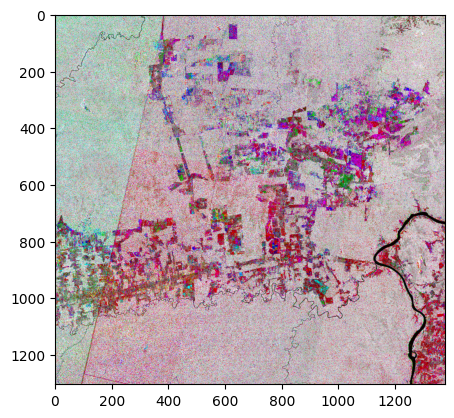

In [9]:
plt.imshow(normalise_bands(out,2,98))

In [10]:
from PIL import Image
im_out_8bit = (255*np.clip(normalise_bands(out,2,98),0,1)).astype(np.uint8)
im_out_8bit_resized = cv2.resize(im_out_8bit, (0, 0), fx=0.5, fy=0.5)
Image.fromarray(im_out_8bit_resized).save('s1_cd.png')